In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from astropy.io import ascii
%matplotlib inline

In [2]:
SNdata = ascii.read('lcparam_DS17f.txt')

In [3]:
SNdata

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18
int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
0,0.014,0.014,0.0,14.57001926,0.0311,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0194,0.0194,0.0,15.2279603507,0.02645,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0264,0.0264,0.0,15.934102317,0.0231,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0329,0.0329,0.0,16.4217829558,0.0235,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0396,0.0396,0.0,16.836418956,0.02845,0,0,0,0,0,0,0,0,0,0,0,0
5,0.0475,0.0475,0.0,17.2346439906,0.0334,0,0,0,0,0,0,0,0,0,0,0,0
6,0.056,0.056,0.0,17.5758459622,0.03215,0,0,0,0,0,0,0,0,0,0,0,0
7,0.064,0.064,0.0,17.9104543501,0.0439,0,0,0,0,0,0,0,0,0,0,0,0
8,0.0721,0.0721,0.0,18.1780074589,0.03865,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
def calculate_apparent_mag(params, SNdata):
    '''                                                                                               
    Parameters                                                                                        
    ----------                                                                                        
    Computes apparent magnitudes for an array of observed SN by using their                           
    redshift data along with assumed cosmology parameters to compute a                                
    luminosity distance for each SN, after which it is converted into a                               
    distance modulus and combined with an input absolute magnitude to finally                         
    ouput apparent magnitudes.                                                                        
                                                                                                      
    Note that for calculating luminosity distance we use the following                                
    relations based on curvature:                                                                     
    For k = 0: dL = (c(1+z)/H0)*(int^z_0 dz/E(z))                                                     
    For k > 0: dL = (c(1+z)/H0)*(1/sqrt(abs(OmegaK))) \                                               
                    *sin(sqrt(abs(OmegaK))*(int^z_0 dz/E(z)))                                         
    For k < 0: dL = (c(1+z)/H0)*(1/sqrt(abs(OmegaK))) \                                               
                    *sinh(sqrt(abs(OmegaK))*(int^z_0 dz/E(z)))                                        
    Here E(z) = sqrt(OmegaM(1+z)^3 + OmegaLambda + OmegaK(1+z)^2)                                     
                                                                                                      
    Also note that in order to get the final dL in units of [pc] for use                              
    in calculating the distance modulus, we input c in units of [km/s]                                
    and H0 in units of [km/s/pc]. The value of c is hard-coded in while                               
    H0 is multiplied by 10^-6 to convert from [km/s/Mpc] to [km/s/pc].                                
                                                                                                      
    params: array of 4 input parameters based on our assumed LambdaCDM-K                              
            cosmology model (in order)                                                                
            OmegaM: energy density of matter [dimensionless]                                          
            OmegaLambda: energy density of dark energy [dimensionless]                                
            H0: present-day value of Hubble parameter [needs to be in km/s/Mpc]                       
            M: fiducial SN Ia absolute magnitude [dimensionless]                                      
    SNdata: 2D data table consisting of the following values for each                                 
            SN Ia (in order)                                                                          
            mb: apparent magnitude in B band [dimensionless]                                          
            dmb: error on apparent magnitude [dimensionless]                                          
            zhel: redshift [dimensionless]                                   
    
    Returns                                                                                           
    -------                                                                                           
    apparent_mags: array of calculated apparent magnitude values for                                  
                   each SN Ia based on our assumed cosmology                                          
    '''

    c = 3.0*(10**5)                       # speed of light in km/s                                    
    apparent_mags = [0.0]*len(SNdata)     # to store calculated m values for each SN                  

    OmegaK = 1 - params[0] - params[1]    # based on sum(Omega_i) = 1                                 

    # looping over each SN in the dataset                                                             
    for i in range(0, len(SNdata['col2'])):

        f = lambda x: ((params[0]*((1+x)**3)) + (params[1]) + \
                      (OmegaK*((1+x)**2)))**-0.5
        eta, etaerr = integrate.quad(f, 0.0, SNdata['col2'][i])

        # note here that dL ends up being in units of pc                                              
        if OmegaK == 0.0:
            dL = (c*(1+SNdata['col2'][i])/(params[2]*(10**-6))) * eta
        elif OmegaK > 0.0:
            dL = (c*(1+SNdata['col2'][i])/(params[2]*(10**-6))) * (1/math.sqrt(abs(OmegaK))) \
                 * math.sin(math.sqrt(abs(OmegaK)) * eta)
        elif OmegaK < 0.0:
            dL = (c*(1+SNdata['col2'][i])/(params[2]*(10**-6))) *(1/math.sqrt(abs(OmegaK))) \
                 * math.sinh(math.sqrt(abs(OmegaK)) * eta)

        apparent_mags[i] = 5*math.log10(dL/10.0) + params[3]

    return apparent_mags

In [7]:
def test_apparent_mag_fn(SNdata):
    '''
    Testing with default parameters of:
    OmegaM = 0.3, OmegaLambda = 0.7, H0 = 70km/s/Mpc, M = -19.3
    '''
    
    params = [0.3, 0.7, 70, -19.3]
    
    m = calculate_apparent_mag(params, SNdata)
    
    mu = []
    for i in range(0, len(m)):
        mu.append(m[i] - params[3])
    
    plt.scatter(SNdata['col2'], mu)
    plt.xlabel('Redshift [z]', fontsize=12)
    plt.ylabel('Distance Modulus [$\\mu$]', fontsize=12)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

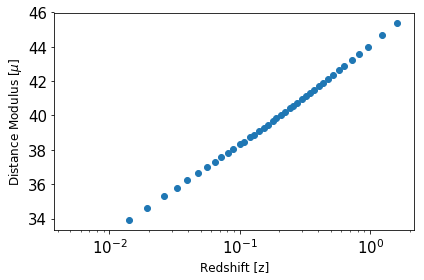

In [8]:
test_apparent_mag_fn(SNdata)